In [1]:
from __future__ import annotations

import json
from pathlib import Path
from typing import Any, Dict, List

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

DATASET_LABELS = {
    'open_compas': 'OpenML COMPAS',
    'openml_bank_marketing': 'OpenML Bank Marketing',
    'openml_german_credit': 'OpenML German Credit',
}
MODEL_LABELS = {
    'decision_tree': 'Decision Tree',
    'gradient_boosting': 'Gradient Boosting',
    'logistic_regression': 'Logistic Regression',
    'mlp_classifier': 'Multilayer Perceptron',
}

# Path to either a single simulation JSON or a directory containing multiple JSON files.
RESULTS_PATH = Path('../../results/hc_combo_20251228_050331/preference_learning_simulation_aligned/aut_xai_comp_all-metrics')
# Optional filters.
PERSONA_FILTER: str | None = None  # e.g. 'clinician' / 'regulator' / 'lay_user'
K_TO_PLOT = 3

def _suffix_from_path(path: Path) -> str:
    token = path.parent.name if path.suffix else path.name
    token = token or 'reports'
    return token.replace(' ', '_')

RUN_SUFFIX = _suffix_from_path(RESULTS_PATH)
REPORTS_DIR = (RESULTS_PATH.parent if RESULTS_PATH.suffix else RESULTS_PATH) / 'reports'
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

sns.set_theme(style='whitegrid')


In [2]:
def _iter_result_paths(path: Path) -> List[Path]:
    if path.is_dir():
        persona_jsons = list(path.rglob('persona_simulation_summary.json'))
        if persona_jsons:
            return sorted(persona_jsons)
        return sorted(path.rglob('*.json'))
    if path.is_file():
        return [path]
    return []


def load_simulation_results(path: Path = RESULTS_PATH) -> pd.DataFrame:
    records: List[Dict[str, object]] = []
    for json_path in _iter_result_paths(path):
        payload: Dict[str, Any] = json.loads(json_path.read_text(encoding='utf-8'))
        dataset = payload.get('dataset')
        model = payload.get('model')
        persona = payload.get('persona')
        tau = (
            (payload.get('persona_sampling') or {}).get('tau_override')
            or (payload.get('persona_config') or {}).get('tau')
        )
        if tau is None:
            per_user = payload.get('per_user') or []
            if per_user and isinstance(per_user, list) and isinstance(per_user[0], dict):
                tau = per_user[0].get('tau')
        try:
            tau = float(tau) if tau is not None else None
        except Exception:
            tau = None

        for method, key in (
            ('PersoXAI', 'aggregate_top_k_mean'),
            ('autoxai', 'aggregate_autoxai_top_k_mean'),
        ):
            top_k = payload.get(key) or {}
            for k, stats in top_k.items():
                try:
                    k_int = int(k)
                except Exception:
                    continue
                spearman = 0.0
                if isinstance(stats, dict):
                    rank_corr = stats.get('rank_correlation')
                    if isinstance(rank_corr, dict):
                        spearman = float(rank_corr.get('spearman') or 0.0)
                    else:
                        spearman = float(stats.get('rank_correlation.spearman') or 0.0)
                records.append(
                    {
                        'file': json_path.name,
                        'dataset': dataset,
                        'model': model,
                        'persona': persona,
                        'tau': tau,
                        'method': method,
                        'k': k_int,
                        'precision': float((stats or {}).get('precision', 0.0)),
                        'recall': float((stats or {}).get('recall', 0.0)),
                        'jaccard': float((stats or {}).get('jaccard', 0.0)),
                        'spearman': spearman,
                    }
                )
    df = pd.DataFrame(records)
    if df.empty:
        print(f'No simulation results found under: {path.resolve()}')
        return df
    print(f'Loaded {len(df)} rows from {df["file"].nunique()} JSON file(s).')
    return df


results_df = load_simulation_results()
results_df.head()


Loaded 72 rows from 12 JSON file(s).


,file,dataset,model,persona,tau,method,k,precision,recall,jaccard,spearman
0,persona_simulation_summary__open_compas__decis...,open_compas,decision_tree,auto-xai-persona,0.01,PersoXAI,3,0.958750,0.958750,0.938125,0.837250
1,persona_simulation_summary__open_compas__decis...,open_compas,decision_tree,auto-xai-persona,0.01,PersoXAI,5,0.963000,0.963000,0.938452,0.928161
2,persona_simulation_summary__open_compas__decis...,open_compas,decision_tree,auto-xai-persona,0.01,PersoXAI,8,0.972031,0.972031,0.950389,0.961116
3,persona_simulation_summary__open_compas__decis...,open_compas,decision_tree,auto-xai-persona,0.01,autoxai,3,0.726250,0.726250,0.633250,0.374250
4,persona_simulation_summary__open_compas__decis...,open_compas,decision_tree,auto-xai-persona,0.01,autoxai,5,0.761750,0.761750,0.648348,0.505618


In [4]:
# Inspect encoded dataset sizes referenced by the simulation results.
ENCODED_BASE_DIR = Path('../../results') / 'hc_combo_20251228_050331' / 'encoded_pareto_fronts' / 'features_full_lm_stats'
encoded_paths_raw = []
for json_path in _iter_result_paths(RESULTS_PATH):
    payload = json.loads(json_path.read_text(encoding='utf-8'))
    encoded_path_val = payload.get('encoded_path')
    if encoded_path_val:
        encoded_paths_raw.append(encoded_path_val)

def _resolve_encoded_path(path_str: str) -> Path:
    path = Path(path_str)
    candidates = [
        path,
        Path.cwd() / path,
        RESULTS_PATH.parent / path,
        ENCODED_BASE_DIR / path.name,
    ]
    for candidate in candidates:
        if candidate.exists():
            return candidate
    return path

encoded_paths = sorted({str(_resolve_encoded_path(p)) for p in encoded_paths_raw})
encoded_stats_rows: list[dict[str, object]] = []
for raw_path in encoded_paths:
    resolved = Path(raw_path)
    exists = resolved.exists()
    rows = None
    cols = None
    error = None
    if exists:
        try:
            df = pd.read_parquet(resolved)
            rows = len(df)
            cols = len(df.columns)
        except Exception as exc:  # pragma: no cover - notebook debug helper
            error = str(exc)
    encoded_stats_rows.append(
        {
            'encoded_path': str(resolved),
            'exists': bool(exists),
            'rows': rows,
            'columns': cols,
            'error': error,
        }
    )

encoded_stats_df = pd.DataFrame(encoded_stats_rows)
print(f'Found {len(encoded_paths)} encoded file(s) referenced in results.')
encoded_stats_df


Found 12 encoded file(s) referenced in results.


,encoded_path,exists,rows,columns,error
0,../../results/hc_combo_20251228_050331/encoded...,True,1463,73,None
1,../../results/hc_combo_20251228_050331/encoded...,True,1488,73,None
2,../../results/hc_combo_20251228_050331/encoded...,True,1588,73,None
3,../../results/hc_combo_20251228_050331/encoded...,True,1616,73,None
4,../../results/hc_combo_20251228_050331/encoded...,True,914,73,None
5,../../results/hc_combo_20251228_050331/encoded...,True,1513,73,None
6,../../results/hc_combo_20251228_050331/encoded...,True,1675,73,None
7,../../results/hc_combo_20251228_050331/encoded...,True,1727,73,None
8,../../results/hc_combo_20251228_050331/encoded...,True,1187,73,None
9,../../results/hc_combo_20251228_050331/encoded...,True,1640,73,None


In [6]:
def _format_label(name: object) -> str:
    if not isinstance(name, str) or not name:
        return 'Unknown'
    return name.replace('_', ' ').title()

if not results_df.empty:
    results_df['dataset_label'] = results_df['dataset'].map(DATASET_LABELS).fillna(results_df['dataset'].apply(_format_label))
    results_df['model_label'] = results_df['model'].map(MODEL_LABELS).fillna(results_df['model'].apply(_format_label))
    if PERSONA_FILTER is not None:
        results_df = results_df[results_df['persona'] == PERSONA_FILTER].copy()

plot_df = results_df[results_df['k'] == int(K_TO_PLOT)].copy() if not results_df.empty else results_df
plot_df.head()


,file,dataset,model,persona,tau,method,k,precision,recall,jaccard,spearman,dataset_label,model_label
0,persona_simulation_summary__open_compas__decis...,open_compas,decision_tree,auto-xai-persona,0.01,PersoXAI,3,0.958750,0.958750,0.938125,0.837250,OpenML COMPAS,Decision Tree
3,persona_simulation_summary__open_compas__decis...,open_compas,decision_tree,auto-xai-persona,0.01,autoxai,3,0.726250,0.726250,0.633250,0.374250,OpenML COMPAS,Decision Tree
6,persona_simulation_summary__open_compas__gradi...,open_compas,gradient_boosting,auto-xai-persona,0.01,PersoXAI,3,0.959167,0.959167,0.938750,0.837750,OpenML COMPAS,Gradient Boosting
9,persona_simulation_summary__open_compas__gradi...,open_compas,gradient_boosting,auto-xai-persona,0.01,autoxai,3,0.693750,0.693750,0.594875,0.285321,OpenML COMPAS,Gradient Boosting
12,persona_simulation_summary__open_compas__logis...,open_compas,logistic_regression,auto-xai-persona,0.01,PersoXAI,3,0.950833,0.950833,0.926750,0.836500,OpenML COMPAS,Logistic Regression


Loaded 144 rows from 48 JSON file(s).


/tmp/ipykernel_117405/3088575171.py:74: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = spearman_df.pivot_table(


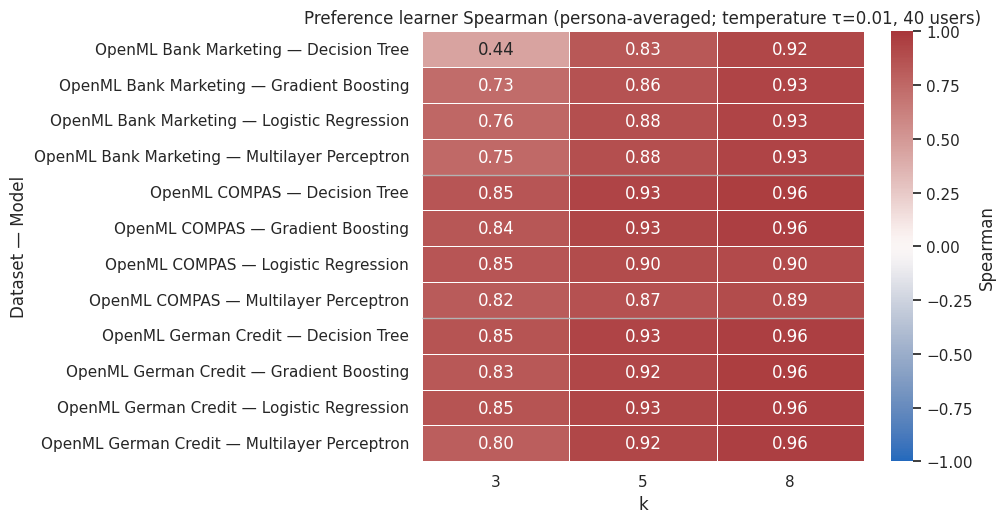

In [7]:
# Spearman heatmap (persona-averaged): preference learner only (all personas)
# Combined into a single heatmap since there's only one ranker.

PREFERENCE_ONLY_RESULTS_PATH = Path(
    '../../results/hc_combo_20251228_050331/preference_learning_simulation_aligned/preference_only_all_personas'
)
PREFERENCE_ONLY_RUN_SUFFIX = _suffix_from_path(PREFERENCE_ONLY_RESULTS_PATH)
PREFERENCE_ONLY_REPORTS_DIR = (
    (PREFERENCE_ONLY_RESULTS_PATH.parent if PREFERENCE_ONLY_RESULTS_PATH.suffix else PREFERENCE_ONLY_RESULTS_PATH)
    / 'reports'
)
PREFERENCE_ONLY_REPORTS_DIR.mkdir(parents=True, exist_ok=True)

preference_only_results_df = load_simulation_results(PREFERENCE_ONLY_RESULTS_PATH)
if not preference_only_results_df.empty:
    preference_only_results_df = preference_only_results_df[
        preference_only_results_df['method'] == 'PersoXAI'
    ].copy()

K_VALUES = [3, 5, 8]
DATASETS_TO_PLOT = ['open_compas', 'openml_bank_marketing', 'openml_german_credit']

spearman_source = preference_only_results_df.copy()
if spearman_source.empty:
    print('No preference-only results loaded (check PREFERENCE_ONLY_RESULTS_PATH).')
else:
    spearman_df = (
        spearman_source[spearman_source['k'].isin(K_VALUES)]
        .groupby(['persona', 'dataset', 'model', 'k'])['spearman']
        .mean()
        .reset_index()
        .groupby(['dataset', 'model', 'k'])['spearman']
        .mean()
        .reset_index()
    )

    spearman_df['dataset_label'] = (
        spearman_df['dataset']
        .map(DATASET_LABELS)
        .fillna(spearman_df['dataset'].apply(_format_label))
    )
    spearman_df['model_label'] = (
        spearman_df['model']
        .map(MODEL_LABELS)
        .fillna(spearman_df['model'].apply(_format_label))
    )

    tau_values = []
    if 'tau' in spearman_source.columns:
        tau_values = [v for v in spearman_source['tau'].dropna().unique().tolist() if v is not None]
    tau_values = sorted(set(float(v) for v in tau_values))
    if len(tau_values) == 1:
        temperature_title = f"τ={tau_values[0]:g}"
    elif len(tau_values) == 0:
        temperature_title = 'τ=?'
    else:
        temperature_title = f"τ∈[{min(tau_values):g}, {max(tau_values):g}]"

    datasets = [d for d in DATASETS_TO_PLOT if (spearman_df['dataset'] == d).any()]
    if not datasets:
        datasets = sorted(spearman_df['dataset'].dropna().unique().tolist())

    # Build a single (dataset, model) x k table.
    model_order = [
        MODEL_LABELS.get(model_key, _format_label(model_key))
        for model_key in MODEL_LABELS
        if (spearman_df['model'] == model_key).any()
    ]

    spearman_df['dataset'] = pd.Categorical(spearman_df['dataset'], categories=datasets, ordered=True)
    if model_order:
        spearman_df['model_label'] = pd.Categorical(spearman_df['model_label'], categories=model_order, ordered=True)

    pivot = spearman_df.pivot_table(
        index=['dataset_label', 'model_label'],
        columns='k',
        values='spearman',
        aggfunc='mean',
    ).reindex(columns=K_VALUES)

    # Flatten the MultiIndex for compact y tick labels.
    yticklabels = [f"{ds} — {model}" for ds, model in pivot.index]

    n_rows = len(pivot)
    fig_h = max(4.5, 0.45 * n_rows)
    fig, ax = plt.subplots(figsize=(10, fig_h))
    sns.heatmap(
        pivot,
        annot=True,
        fmt='.2f',
        cmap='vlag',
        vmin=-1,
        vmax=1,
        linewidths=0.5,
        linecolor='white',
        cbar_kws={'label': 'Spearman'},
        ax=ax,
    )
    ax.set_yticklabels(yticklabels, rotation=0)
    ax.set_xlabel('k')
    ax.set_ylabel('Dataset — Model')

    # Add separators between datasets.
    if hasattr(pivot.index, 'levels') and len(pivot.index.levels) == 2:
        counts_by_dataset = (
            pivot.reset_index()[['dataset_label', 'model_label']]
            .groupby('dataset_label', sort=False)
            .size()
            .tolist()
        )
        offset = 0
        for count in counts_by_dataset[:-1]:
            offset += count
            ax.hlines(offset, *ax.get_xlim(), colors='0.7', linewidth=1.0)

    ax.set_title(
        f"Preference learner Spearman (persona-averaged; temperature {temperature_title}, 40 users)"
    )
    fig.tight_layout()

    out_base = f"spearman_heatmap_preference_only_combined_{PREFERENCE_ONLY_RUN_SUFFIX}"
    fig.savefig(PREFERENCE_ONLY_REPORTS_DIR / f"{out_base}.png", dpi=300, bbox_inches='tight')
    fig.savefig(PREFERENCE_ONLY_REPORTS_DIR / f"{out_base}.pdf", dpi=300, bbox_inches='tight', format='pdf')
    pivot.reset_index().to_csv(PREFERENCE_ONLY_REPORTS_DIR / f"{out_base}.csv", index=False)
    plt.show()
    plt.close(fig)


In [8]:
# --- Compact single-heatmap version (one column per dataset×k) ---

K_VALUES = [3, 5, 8]
DATASETS_TO_PLOT = ['open_compas', 'openml_bank_marketing', 'openml_german_credit']

# Which ranker/method to plot (choose one)
SINGLE_METHOD_KEY = 'perso_xai'   # or 'autoxai' etc.
SINGLE_METHOD_LABEL = 'PersoXAI'  # label used in plot title / column naming

DATASET_SHORT = {
    'open_compas': 'COMPAS',
    'openml_bank_marketing': 'BANK',
    'openml_german_credit': 'GERMAN',
}

# --- Filter to single method ---
single_df = spearman_df[spearman_df["method"] == SINGLE_METHOD_KEY].copy()
if single_df.empty:
    print(f"No rows found for method={SINGLE_METHOD_KEY}. Check method names in spearman_df['method'].unique().")
else:
    # Datasets to include (preserve preferred order)
    datasets = [d for d in DATASETS_TO_PLOT if (single_df['dataset'] == d).any()]
    if not datasets:
        datasets = sorted(single_df['dataset'].dropna().unique().tolist())

    # --- Build wide table: rows=models, cols=(dataset,k) ---
    wide = (
        single_df
        .pivot_table(
            index='model_label',
            columns=['dataset', 'k'],
            values='spearman',
            aggfunc='mean'
        )
    )

    # Enforce column order: dataset order × K order
    ordered_cols = []
    for d in datasets:
        for k in K_VALUES:
            col = (d, int(k))
            if col in wide.columns:
                ordered_cols.append(col)

    wide = wide.reindex(columns=pd.MultiIndex.from_tuples(ordered_cols, names=wide.columns.names))

    # Enforce model order (same idea as your original)
    present_models = set(single_df['model'])
    model_order = [
        MODEL_LABELS.get(model_key, _format_label(model_key))
        for model_key in MODEL_LABELS
        if model_key in present_models
    ]
    if model_order:
        wide = wide.reindex(model_order)

    # Flatten column names into compact strings: e.g., COMPAS-3
    def _col_label(d, k):
        d_short = DATASET_SHORT.get(d, DATASET_LABELS.get(d, _format_label(d)))
        return f"{d_short}-{int(k)}"

    wide.columns = [_col_label(d, k) for (d, k) in wide.columns]

    # --- Plot ---
    ncols = wide.shape[1]
    nrows = wide.shape[0]

    fig_w = max(10, 0.45 * ncols)   # tweak as desired
    fig_h = max(3.2, 0.55 * nrows)
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))

    mask = wide.isna()
    sns.heatmap(
        wide,
        annot=True,
        fmt='.2f',
        cmap='vlag',
        vmin=-1,
        vmax=1,
        mask=mask,
        cbar=True,
        cbar_kws={'label': 'Spearman'},
        ax=ax,

        # readability
        linewidths=0.8,
        linecolor='white',
        annot_kws={'fontsize': 9},
    )

    ax.set_xlabel('')
    ax.set_ylabel('Model')

    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center', fontsize=9)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)

    # Optional separators:
    # 1) between each dataset block (every len(K_VALUES) columns)
    if len(K_VALUES) > 0:
        for x in range(len(K_VALUES), ncols, len(K_VALUES)):
            ax.axvline(x, color='white', linewidth=2)

    # 2) OR, if you prefer separators between each k (comment above + uncomment below)
    # for x in range(1, ncols):
    #     ax.axvline(x, color='white', linewidth=1.2)

    # Optional title
    # ax.set_title(
    #     f"Spearman Rank Correlation (persona-averaged; temperature {temperature_title}, 40 users): {SINGLE_METHOD_LABEL}"
    # )

    fig.tight_layout()

    out_base = f"spearman_heatmap_compact_{SINGLE_METHOD_LABEL}_{PREFERENCE_ONLY_RUN_SUFFIX}"
    fig.savefig(PREFERENCE_ONLY_REPORTS_DIR / f"{out_base}.png", dpi=300, bbox_inches='tight')
    fig.savefig(PREFERENCE_ONLY_REPORTS_DIR / f"{out_base}.pdf", dpi=300, bbox_inches='tight', format='pdf')

    # Save compact matrix values (easy to inspect)
    wide.to_csv(PREFERENCE_ONLY_REPORTS_DIR / f"{out_base}_values.csv")

    plt.show()
    plt.close(fig)


KeyError: 'method'